## Introduction

NN solver could be used after data format modification (I first created NN solver with custom vertex class and other login, then was BnC algorithm implementation with tsplib. **Compatibility is not purpose** in this case).

**I would recommend** to use `%matplotlib widget` command (interactive plots) instead of `%matplotlib inline`.

**Assumptions**:
- TSP is symmetrical.
- Triangle inequality is satisfied

**Terminology** is aligned with tsplib library, e.g. *tour* is a list of node indexes, etc...

### References
- [tsplib](https://tsplib95.readthedocs.io/en/stable/pages/usage.html) documentation
- base [guideline](https://faculty.math.illinois.edu/~mlavrov/slides/482-spring-2020/slides35.pdf) for solution
- [lin prog with python](https://realpython.com/linear-programming-python/)

In [1]:
# %matplotlib widget  # Recommended
%matplotlib inline

import os
import tsplib95

from pulp import LpMinimize, LpProblem, LpStatus, LpVariable, LpAffineExpression, GLPK, pulpTestAll, lpSum
from matplotlib import pyplot as plt
from collections import Counter

In [ ]:
# Make sure it run with no errors
# Install required sw to proceed
pulpTestAll()

In [8]:
VERBOSE = False
PLOT = True
DATA_SET = 'berlin52'
TSP_ROOT = './tsp/'

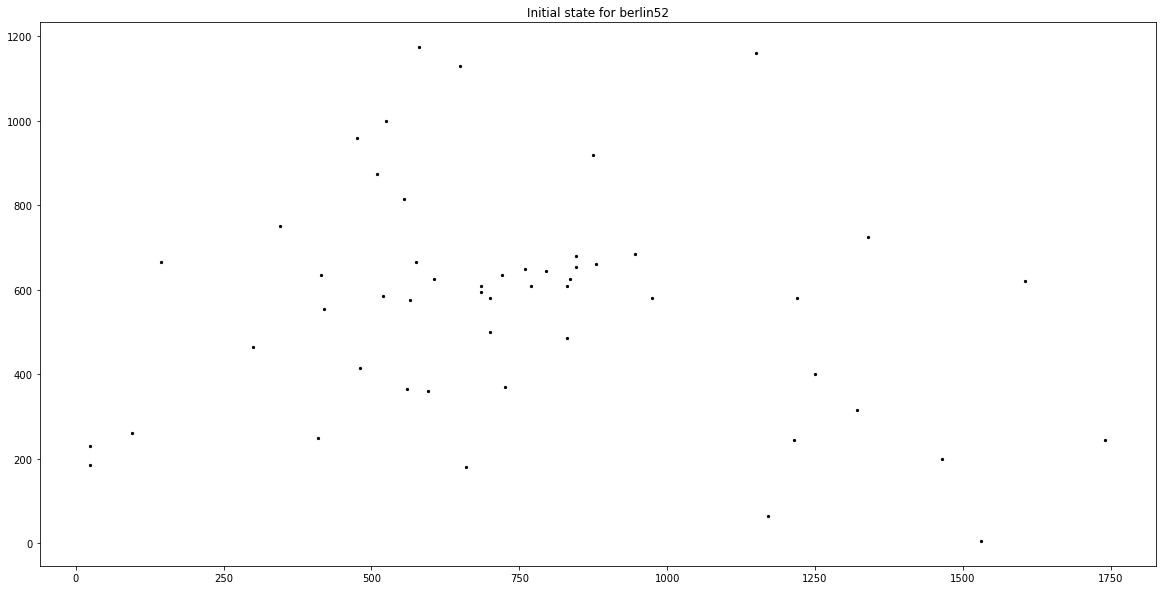

In [6]:
problem = tsplib95.load(os.path.join(TSP_ROOT, f'{DATA_SET}.tsp'))

assert problem.is_symmetric()
assert problem.edge_weight_type == 'EUC_2D'

if PLOT:
    plt.figure(figsize=(20, 10))
    ax = plt.subplot()
    ax.set_title(f'Initial state for {DATA_SET}')

    for x, y in problem.node_coords.values():
        ax.scatter(x, y, s=5, color='k')

Status: 1, Optimal
Path length: 7164.0


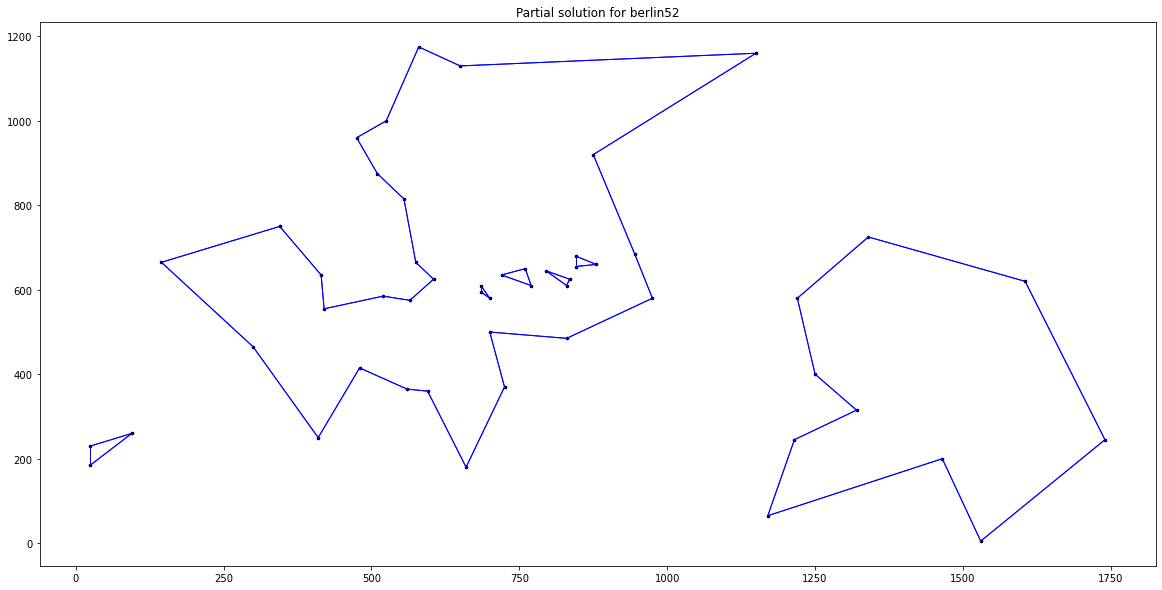

In [18]:
n = len(list(problem.get_nodes()))
model = LpProblem(name="tsp", sense=LpMinimize)

def get_edge_name(a, b):
    return f'x_{a}_{b}'

# Build Xij variables - fox each xi to each xj (exclude xi to xi)
edges = {}
for xi in problem.get_nodes():
    for xj in problem.get_nodes():
        if xi != xj: 
            name = get_edge_name(xi, xj)
            edges[name] = (LpVariable(name, cat='Binary'), xi, xj)

# Build cost function
costs = []
for x, xi, xj in edges.values():
    cost = problem.get_weight(xi, xj)
    costs.append((x, cost))
model += (LpAffineExpression(costs), f'Cost x_{xi}_{xj}')

# Build local constraints
for j in range(1, n + 1):
    for e_x, xi, xj in edges.values():
        if xj == j:
            leave_x = []
            for l_x, xj, xk in edges.values():
                if xj == j and xk != xi:
                    leave_x.append((l_x, 1))
            leave_x.append((e_x, 1))
            model += (LpAffineExpression(leave_x) == 2, f'Visit once x_{xi}_{j}')

model.solve(solver=GLPK(msg=False))

print(f"Status: {model.status}, {LpStatus[model.status]}")

if model.status == 1:
    # Divide by 2 because xi-xj = xj-xi edge
    print(f"Path length: {model.objective.value() / 2}")

    if VERBOSE:
        # Make sure all nodes are used twice as enter, twice as exit
        # Each node should lead to other 2 and the same edges but in reverse directions should exist

        ii = []
        jj = []

        for var in model.variables():
            if var.value():
                x, i, j = var.name.split('_')
                ii.append(i)
                jj.append(j)
        
        if VERBOSE:
            print(f'Enter != 2 (should be empty): {[i for i in dict(Counter(ii)).values() if i != 2]}')
            print(f'Leave != 2 (should be empty): {[j for j in dict(Counter(jj)).values() if j != 2]}')

    if PLOT:
        plt.figure(figsize=(20, 10))
        ax = plt.subplot()
        ax.set_title(f'Partial solution for {DATA_SET}')
        for var in model.variables():
            if var.value():
                _, xi, xj = edges[var.name]
                [xi_x, xi_y], [xj_x, xj_y] = problem.get_display(xi), problem.get_display(xj)
                ax.scatter(xi_x, xi_y, s=5, color='k')
                ax.scatter(xj_x, xj_y, s=5, color='k')
                ax.plot([xi_x, xj_x], [xi_y, xj_y], linewidth=1, color='b')

In [16]:
def detect_tour(m: LpProblem, verbose=VERBOSE):
    # Start at random point and go from i to j, if original i encountered - return tour
    tour = set()
    tour_variables = []

    tour_next_index = None
    tour_prev_index = None
    tour_orig_index = None

    for var in m.variables():
        if var.value():
            x, xi, xj = edges[var.name]

            if verbose:
                print(f'start: {xi} -> {xj}')

            tour_prev_index = tour_orig_index = xi
            tour_next_index = xj
            # Add all points that belong to tour
            tour.add(xi)
            tour.add(xj)
            break

    while True:
        for var in m.variables():
            if var.value():
                x, xi, xj = edges[var.name]

                if xi == tour_next_index and xj != tour_prev_index:
                    if verbose:
                        print(f'next: {xi} -> {xj}')
                    tour_prev_index = xi
                    tour_next_index = xj
                    tour.add(xi)
                    tour.add(xj)
                    break
        else:
            break

        if xj == tour_orig_index:
            break

    for var in m.variables():
        if var.value():
            x, xi, xj = edges[var.name]

            if xi in tour or xj in tour:
                tour_variables.append(x)

    return tour, tour_variables


In [19]:
tour, variables = [], []

while True:
    tour, variables = detect_tour(model)
    if len(tour) == n:
        print('No subtours found, abort')
        break

    tour_str = '_'.join([str(t) for t in tour])
    print(f'Solving fou tour: {tour_str}, length: {len(tour)}')

    leave_from_tour = []
    for i in tour:
        leave_from_i = []
        for name, (x, xi, xj) in edges.items():
            if i == xi and xj not in tour:
                leave_from_i.append(x)
        leave_from_tour.extend(leave_from_i)

    model += (lpSum(leave_from_tour) >= 1, f'Leave tour {tour_str}')

    model.solve()

Solving fou tour: 1_3_4_8_9_10_16_17_18_19_20_21_22_23_25_29_30_31_32_33_41_43_44_45_46_49_50, length: 27
Solving fou tour: 1_3_4_5_6_8_9_10_15_16_17_18_19_20_21_22_23_24_25_29_30_31_32_33_34_35_36_37_38_39_40_41_43_44_45_46_48_49_50, length: 39
Solving fou tour: 1_3_4_5_6_8_9_10_11_12_13_14_15_16_17_18_19_20_21_22_23_24_25_26_27_28_29_30_31_32_33_34_35_36_37_38_39_40_41_43_44_45_46_47_48_49_50_51_52, length: 49
Solving fou tour: 1_2_3_4_7_8_9_10_16_17_18_19_20_21_22_23_25_29_30_31_32_33_41_42_43_44_45_46_49_50, length: 30
Solving fou tour: 1_2_3_4_5_6_7_8_9_10_15_16_17_18_19_20_21_22_23_24_25_29_30_31_32_33_34_35_36_37_38_39_40_41_42_43_44_45_46_48_49_50, length: 42
No subtours found, abort


Status: 1, Optimal
Path length: 7542.0


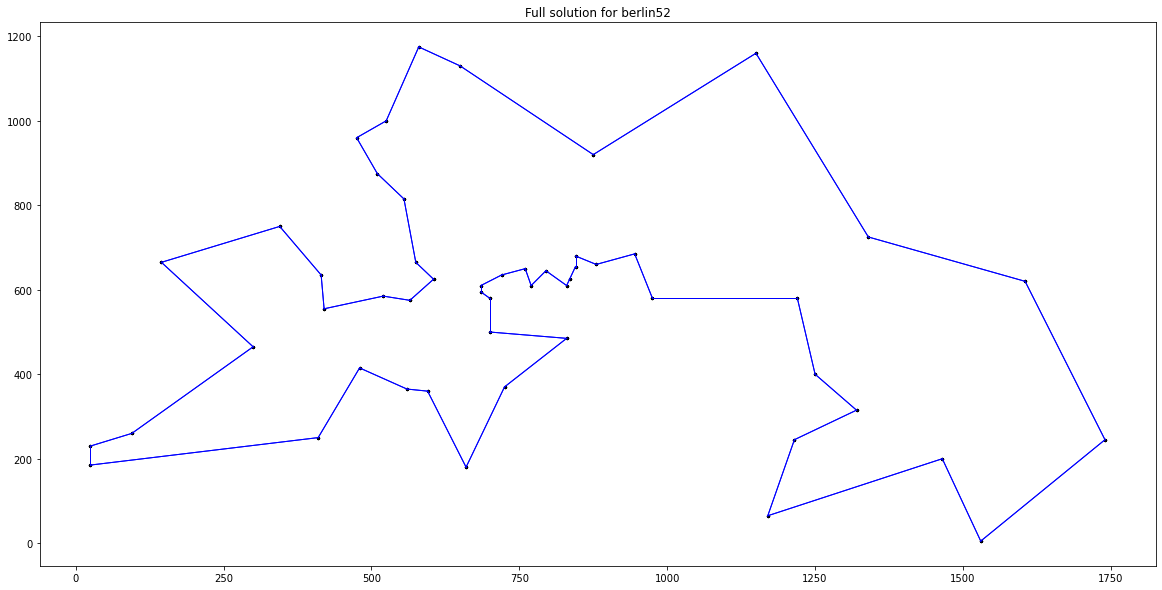

In [21]:
print(f"Status: {model.status}, {LpStatus[model.status]}")

if model.status == 1:
    # Divide by 2 because xi-xj = xj-xi edge
    print(f"Path length: {model.objective.value() / 2}")

    if VERBOSE:
        # Make sure all nodes are used twice as enter, twice as exit
        # Each node should lead to other 2 and the same edges but in reverse directions should exist

        ii = []
        jj = []

        for var in model.variables():
            if var.value():
                x, i, j = var.name.split('_')
                ii.append(i)
                jj.append(j)

        print(f'Enter != 2 (should be empty): {[i for i in dict(Counter(ii)).values() if i != 2]}')
        print(f'Leave != 2 (should be empty): {[j for j in dict(Counter(jj)).values() if j != 2]}')

    if PLOT:
        plt.figure(figsize=(20, 10))
        ax = plt.subplot()
        for var in model.variables():
            if var.value():
                _, xi, xj = edges[var.name]
                [xi_x, xi_y], [xj_x, xj_y] = problem.get_display(xi), problem.get_display(xj)
                ax.scatter(xi_x, xi_y, s=5, color='k')
                ax.scatter(xj_x, xj_y, s=5, color='k')
                ax.plot([xi_x, xj_x], [xi_y, xj_y], linewidth=1, color='b')
        ax.set_title(f'Full solution for {DATA_SET}')